Generating Data

In [1]:
from get_data import OptionPricingDataset, get_train_test_datasets


full_dataset = OptionPricingDataset(ticker="^STOXX50E", start_date="2015-01-01")
X_train, y_train, X_val, y_val = get_train_test_datasets(
        full_dataset, split_ratio=0.8
    )


Génération des données en cours...


In [2]:
print(full_dataset.dates.shape)
print(X_train.shape)

(2773,)
torch.Size([2218, 2])


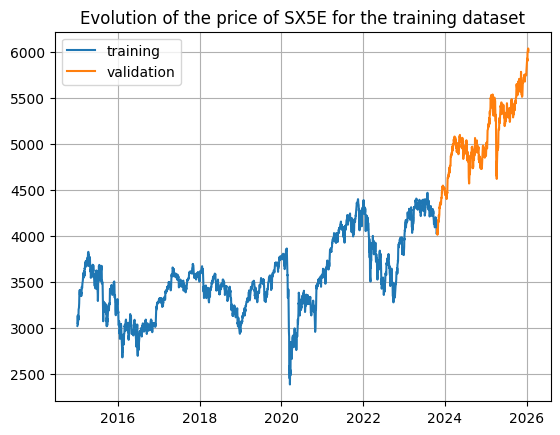

In [3]:
import matplotlib.pyplot as plt

plt.plot(full_dataset.dates[:2218],X_train[:, 0]*full_dataset.strike, label = "training")
plt.plot(full_dataset.dates[2218:],X_val[:, 0]*full_dataset.strike, label = "validation")
plt.legend()

plt.title("Evolution of the price of SX5E for the training dataset")
plt.grid(True)

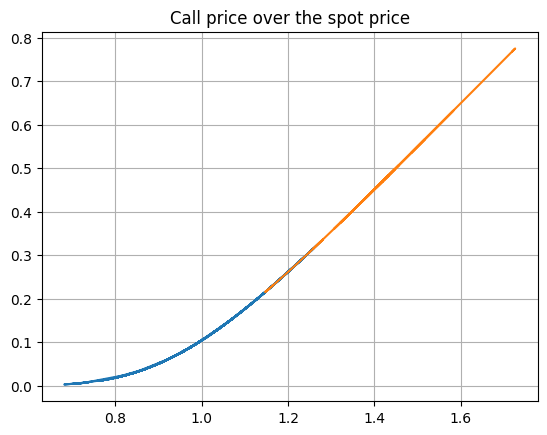

In [4]:
plt.plot(X_train[:,0], y_train, label="training")
plt.plot(X_val[:,0], y_val, label="validation")
plt.title("Call price over the spot price")
plt.grid(True)
plt.show()

In [5]:
from compare_mlp_kan import plot_compare_models
from generate_data import TrainingConfig

training_config = TrainingConfig(batch_size=256, epochs=120)

# plot_compare_models(X_train,y_train, X_val, y_val, full_dataset, training_config=training_config)

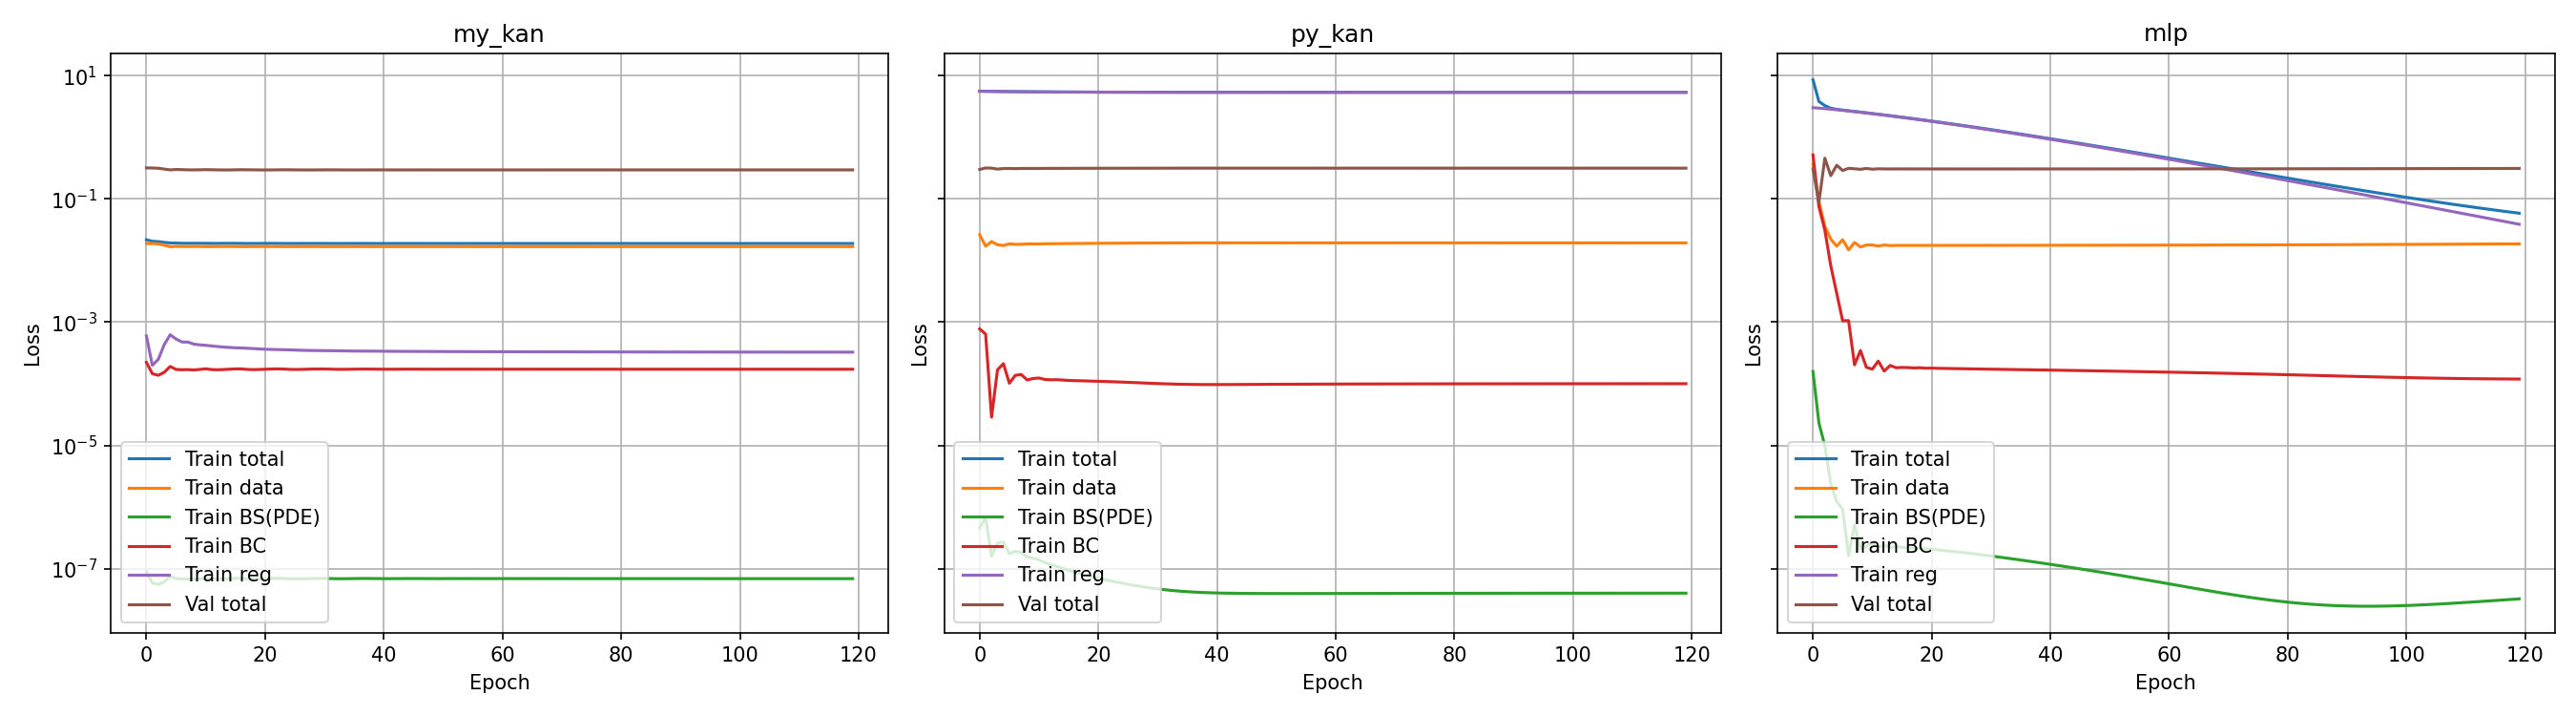

In [6]:
from IPython.display import Image, display

display(Image(filename="resultats/losses.png"))


In [7]:
from generate_data import BatchProvider, TrainingConfig

training_config = TrainingConfig(batch_size=256, epochs=100)

data_train_batches = BatchProvider(
        X_train,
        y_train,
        training_config.batch_size,
        shuffle=True,
        seed=training_config.seed,
    ).batches
data_val_batches = BatchProvider(
        X_val,
        y_val,
        training_config.batch_size,
        shuffle=False,
        seed=training_config.seed,
    ).batches


In [8]:
from generate_data import PINNBatchProvider
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pinn_train = PINNBatchProvider(
        n_batches=len(data_train_batches),
        n_int=training_config.batch_size,
        n_bc=training_config.batch_size,
        S_max=full_dataset.s_max,
        T=full_dataset.maturity,
        K=full_dataset.strike,
        device=device,
        seed=training_config.seed,
    )
pinn_val = PINNBatchProvider(
        n_batches=len(data_val_batches),
        n_int=training_config.batch_size,
        n_bc=training_config.batch_size,
        S_max=full_dataset.s_max,
        T=full_dataset.maturity,
        K=full_dataset.strike,
        device=device,
        seed=training_config.seed + 1,
    )


In [9]:
from generate_data import HybridBatchProvider


train_batches = HybridBatchProvider(data_train_batches, pinn_train).batches
val_batches = HybridBatchProvider(data_val_batches, pinn_val).batches

In [10]:
for batch in train_batches:
    print(batch["boundary"])

(tensor([[1.0000, 0.6236],
        [1.0000, 0.5413],
        [1.0000, 1.0803],
        [1.0000, 1.1691],
        [1.0000, 0.4414],
        [1.0000, 0.9393],
        [1.0000, 1.3632],
        [1.0000, 0.7772],
        [1.0000, 1.1257],
        [1.0000, 0.6549],
        [1.0000, 1.1655],
        [1.0000, 0.2379],
        [1.0000, 0.3555],
        [1.0000, 0.4250],
        [1.0000, 1.6561],
        [1.0000, 0.6308],
        [1.0000, 0.8607],
        [1.0000, 0.4449],
        [1.0000, 1.7246],
        [1.0000, 1.7059],
        [1.0000, 0.2121],
        [1.0000, 0.1634],
        [1.0000, 0.2089],
        [1.0000, 0.8589],
        [1.0000, 0.6430],
        [1.0000, 0.2981],
        [1.0000, 0.5535],
        [1.0000, 1.0261],
        [1.0000, 0.4121],
        [1.0000, 1.0543],
        [1.0000, 0.6651],
        [1.0000, 0.4448],
        [1.0000, 0.9816],
        [1.0000, 1.5726],
        [1.0000, 0.2796],
        [1.0000, 0.9031],
        [1.0000, 0.5448],
        [1.0000, 1.7099],
        [1.

In [11]:
from kan import KAN
from compare_mlp_kan import train_supervised_mse


py_kan = KAN(
        width=[2, 8, 8, 1], grid=5, k=3, seed=training_config.seed, device=str(device)
    )

history = train_supervised_mse(
        py_kan, train_batches, val_batches, training_config, device=device
    )

checkpoint directory created: ./model
saving model version 0.0
Epoch    1/100 | train_loss=2.119e-02 | val_loss=2.158e-01
Epoch   16/100 | train_loss=8.266e-06 | val_loss=2.088e-02
Epoch   32/100 | train_loss=1.558e-06 | val_loss=1.553e-02
Epoch   48/100 | train_loss=1.427e-06 | val_loss=1.469e-02
Epoch   64/100 | train_loss=1.231e-06 | val_loss=1.384e-02
Epoch   80/100 | train_loss=1.060e-06 | val_loss=1.297e-02
Epoch   96/100 | train_loss=9.011e-07 | val_loss=1.214e-02
Epoch  100/100 | train_loss=8.627e-07 | val_loss=1.193e-02


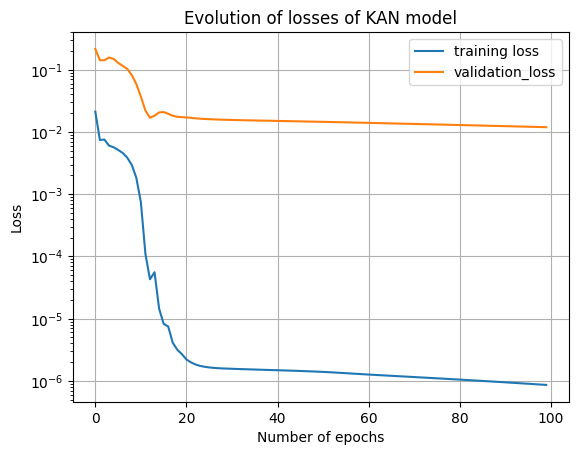

In [12]:
plt.plot(history["train_loss"], label = "training loss")
plt.plot(history['val_loss'], label = "validation_loss")
plt.yscale("log")
plt.grid(True)
plt.title("Evolution of losses of KAN model")
plt.xlabel("Number of epochs")
plt.legend()
plt.ylabel("Loss")
plt.show()

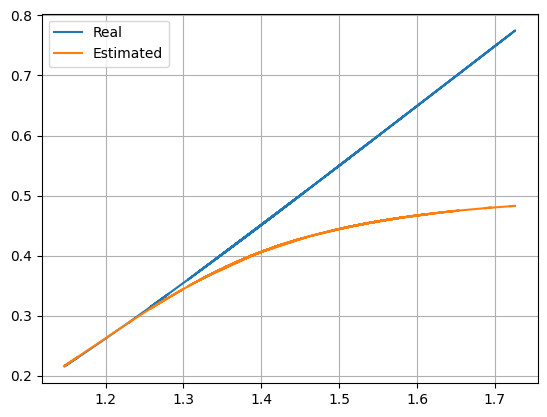

In [13]:
y_estimated = py_kan(X_val)

plt.plot(X_val[:,0], y_val[:,0], label = "Real")
plt.plot(X_val[:,0], y_estimated[:,0].detach(), label = "Estimated")
plt.legend()
plt.grid(True)
plt.show()

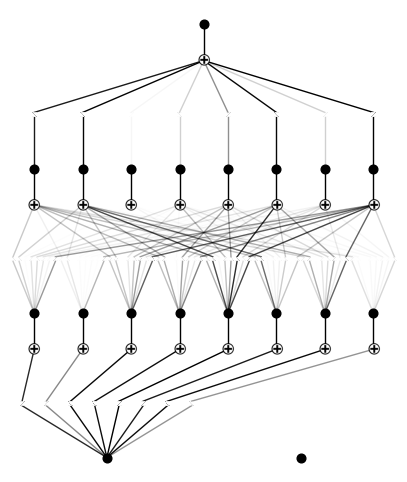

In [14]:
py_kan.plot(beta = 10)

In [29]:
py_kan.prune()

saving model version 0.1


MultKAN(
  (act_fun): ModuleList(
    (0-2): 3 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-2): 3 x Symbolic_KANLayer()
  )
)

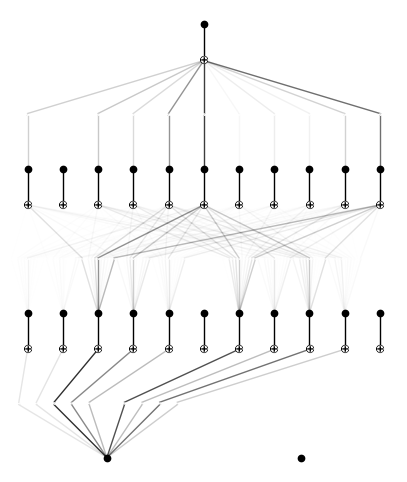

In [30]:
py_kan.plot()

In [31]:
py_kan.suggest_symbolic(0,1,0,weight_simple=0.0)

  function    fitting r2    r2 loss  complexity  complexity loss  total loss
0    1/x^4  1.000000e+00 -16.609640           4                4  -16.609640
1    1/x^3  9.997786e-01 -12.077129           3                3  -12.077129
2    1/x^5  9.997786e-01 -12.077129           5                5  -12.077129
3      exp  1.681628e-05  -0.000010           2                2   -0.000010
4      x^5  5.773507e-10   0.000014           3                3    0.000014


('1/x^4',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  4,
  <function kan.utils.<lambda>(x, y_th)>),
 np.float64(1.0),
 np.int64(4))

In [16]:
nb_layers = [3,5,8,11]
grids = [3,5,7]
ks = [3,4,5]

histories = []
i = 0

for n_layers in nb_layers:
    for grid in grids:
        for k in ks:
            py_kan = KAN(
                width=[2, n_layers, n_layers, 1], grid=grid, k=k, seed=training_config.seed, device=str(device)
                )

            history = train_supervised_mse(py_kan, train_batches, val_batches, training_config, device=device)
            histories.append(history)


checkpoint directory created: ./model
saving model version 0.0
Epoch    1/100 | train_loss=1.672e-02 | val_loss=2.111e-01
Epoch   16/100 | train_loss=8.605e-04 | val_loss=2.621e-02
Epoch   32/100 | train_loss=3.506e-06 | val_loss=9.698e-04
Epoch   48/100 | train_loss=5.977e-07 | val_loss=3.622e-04
Epoch   64/100 | train_loss=2.904e-07 | val_loss=3.119e-04
Epoch   80/100 | train_loss=2.196e-07 | val_loss=3.659e-04
Epoch   96/100 | train_loss=1.633e-07 | val_loss=4.528e-04
Epoch  100/100 | train_loss=1.512e-07 | val_loss=4.771e-04
checkpoint directory created: ./model
saving model version 0.0
Epoch    1/100 | train_loss=1.712e-02 | val_loss=2.139e-01
Epoch   16/100 | train_loss=8.153e-04 | val_loss=2.545e-02
Epoch   32/100 | train_loss=3.870e-06 | val_loss=2.151e-03
Epoch   48/100 | train_loss=1.436e-06 | val_loss=1.138e-03
Epoch   64/100 | train_loss=8.180e-07 | val_loss=8.091e-04
Epoch   80/100 | train_loss=6.765e-07 | val_loss=7.790e-04
Epoch   96/100 | train_loss=6.125e-07 | val_loss

In [19]:
print(histories[0].keys())

dict_keys(['train_loss', 'val_loss'])


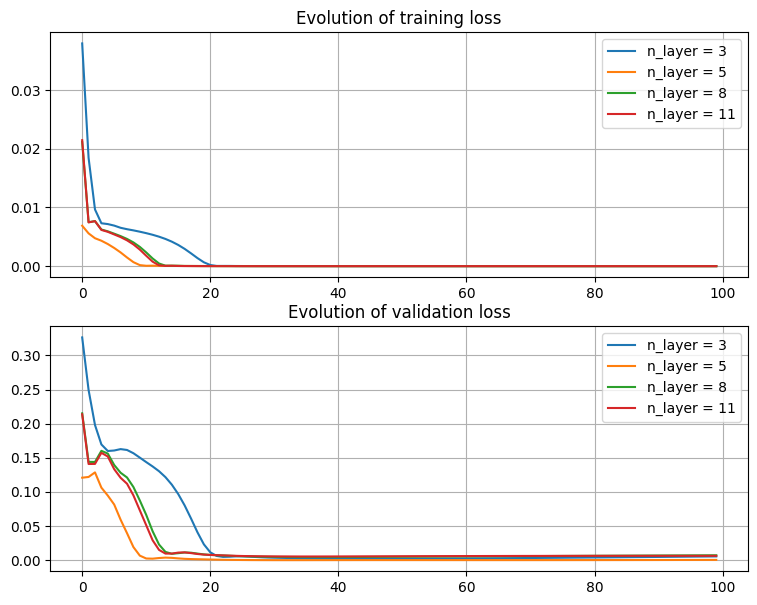

In [ ]:
layers = [5, 14, 23, 22]

fig, axs = plt.subplots(2,1, figsize = (9,7))
for l, n_l in zip(layers, nb_layers):
    axs[0].plot(histories[l]["train_loss"], label = f"n_layer = {n_l}")
    axs[1].plot(histories[l]["val_loss"], label = f"n_layer = {n_l}")

axs[0].legend()
axs[0].grid(True)
axs[0].set_title("Evolution of training loss using differents number of splines")

axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Evolution of validation loss")

plt.show()

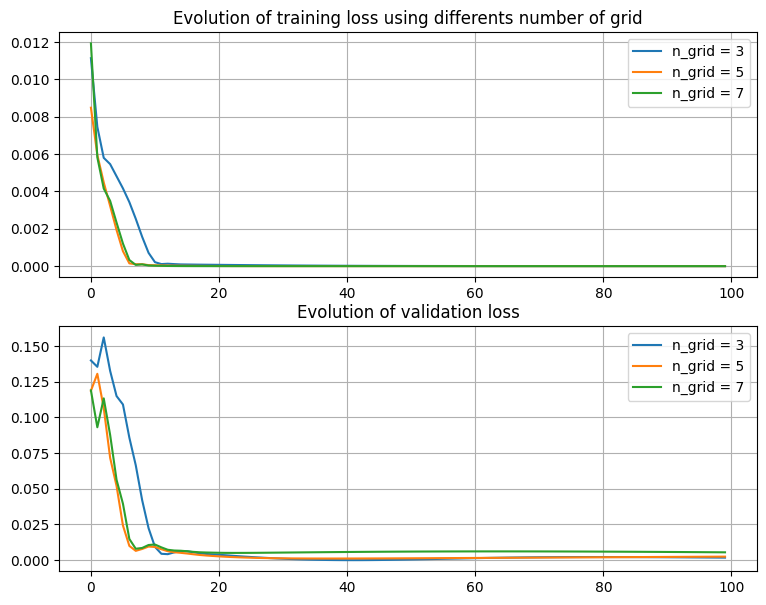

In [28]:
grid_s = [28, 31, 34]

fig, axs = plt.subplots(2,1, figsize = (9,7))
for g, n_g in zip(grid_s, grids):
    axs[0].plot(histories[g]["train_loss"], label = f"n_grid = {n_g}")
    axs[1].plot(histories[g]["val_loss"], label = f"n_grid = {n_g}")

axs[0].legend()
axs[0].grid(True)
axs[0].set_title("Evolution of training loss using differents number of grid")

axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Evolution of validation loss")

plt.show()

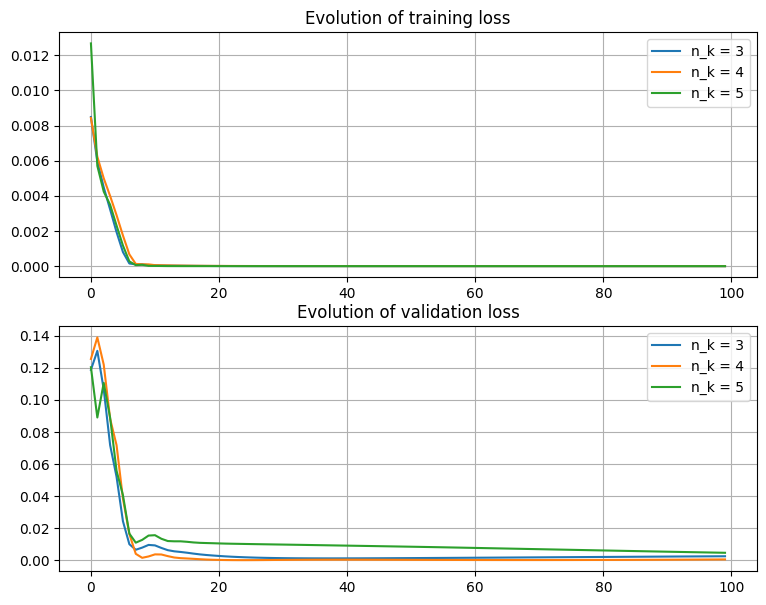

In [27]:
k_s = [31,32,33]

fig, axs = plt.subplots(2,1, figsize = (9,7))
for k, n_k in zip(k_s, ks):
    axs[0].plot(histories[k]["train_loss"], label = f"n_k = {n_k}")
    axs[1].plot(histories[k]["val_loss"], label = f"n_k = {n_k}")

axs[0].legend()
axs[0].grid(True)
axs[0].set_title("Evolution of training loss")

axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Evolution of validation loss")

plt.show()

In [37]:
print(X_train[:5])

tensor([[0.8638, 1.0000],
        [0.8648, 1.0000],
        [0.8957, 1.0000],
        [0.8694, 1.0000],
        [0.8812, 1.0000]])


checkpoint directory created: ./model
saving model version 0.0
Epoch    1/200 | train_loss=1.311e-02 | val_loss=1.706e-01
Epoch   33/200 | train_loss=2.299e-06 | val_loss=2.160e-02
Epoch   66/200 | train_loss=7.642e-07 | val_loss=1.546e-02
Epoch   99/200 | train_loss=2.850e-07 | val_loss=1.186e-02
Epoch  132/200 | train_loss=9.186e-08 | val_loss=9.161e-03
Epoch  165/200 | train_loss=3.629e-08 | val_loss=7.334e-03
Epoch  198/200 | train_loss=1.677e-08 | val_loss=6.234e-03
Epoch  200/200 | train_loss=1.611e-08 | val_loss=6.181e-03


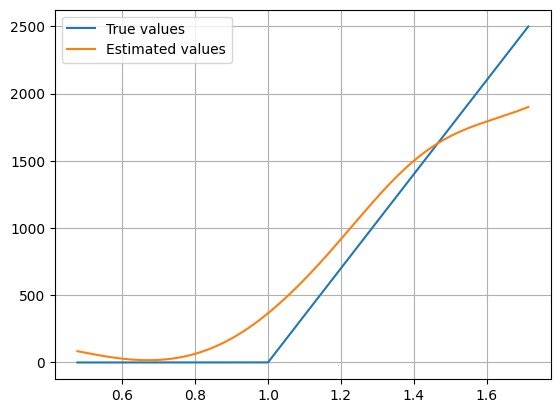

In [65]:
from models.black_scholes import bs_call_price

training_config = TrainingConfig(batch_size=64, epochs=200)

py_kan = KAN(
        width=[2, 8, 8, 1], grid=7, k=4, seed=training_config.seed, device=str(device)
    )

history = train_supervised_mse(
        py_kan, train_batches, val_batches, training_config, device=device
    )

S_test = torch.linspace(0.7*full_dataset.s_min, 6000, steps = 10_000)/full_dataset.strike
time = torch.ones_like(S_test)
X_test = torch.cat([S_test.unsqueeze(1), time.unsqueeze(1)], dim = 1)
y_test = bs_call_price(S_test, time, 1, full_dataset.maturity, full_dataset.rate, sigma = full_dataset.vol)*full_dataset.strike
y_estimated = py_kan(X_test).detach()*full_dataset.strike

plt.plot(X_test[:,0], y_test, label = "True values")
plt.plot(X_test[:,0], y_estimated, label = "Estimated values")
plt.legend()
plt.grid(True)
plt.show()

In [69]:
py_kan.attribute(plot=False)

In [76]:
model_pruned = py_kan.prune_edge(threshold=0.05)


saving model version 0.4


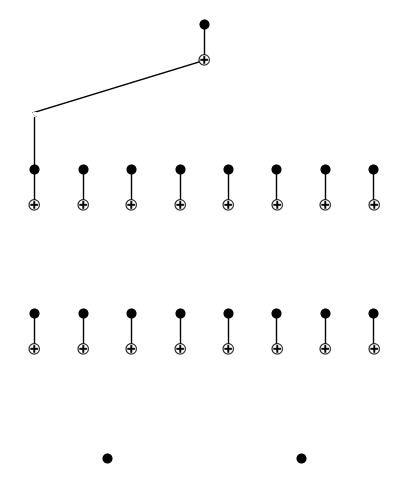

In [77]:
py_kan.plot(beta = 10)

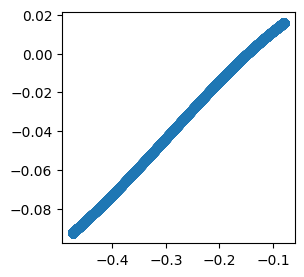

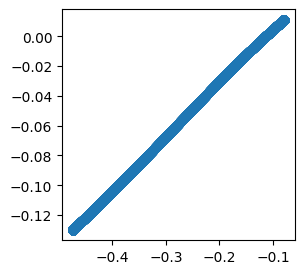

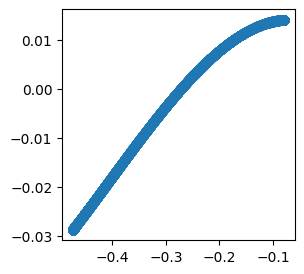

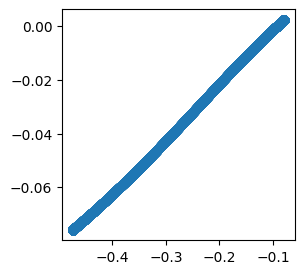

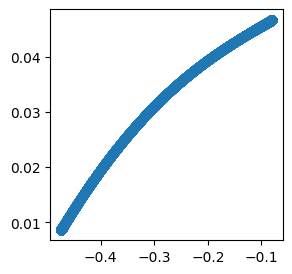

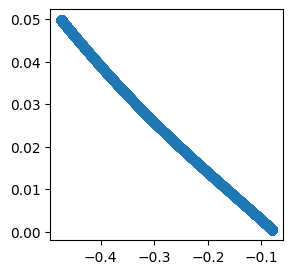

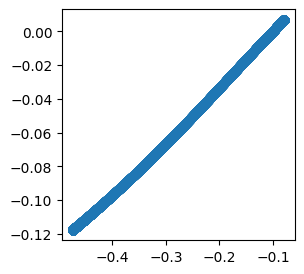

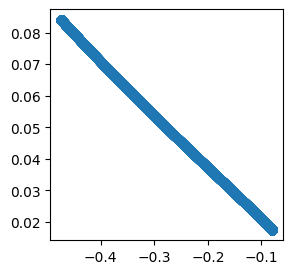

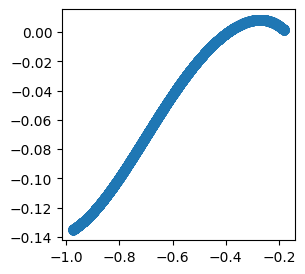

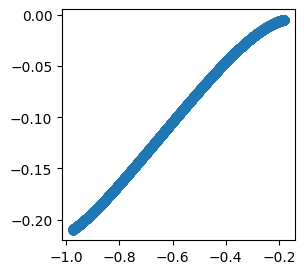

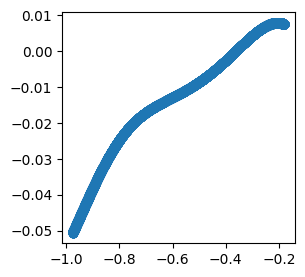

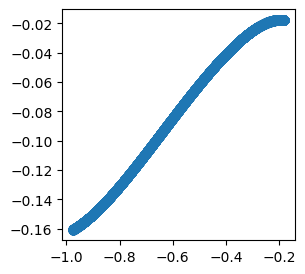

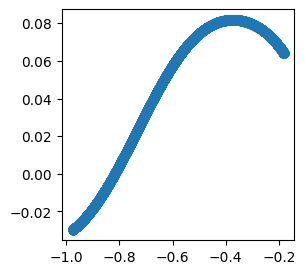

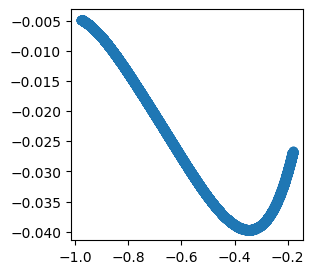

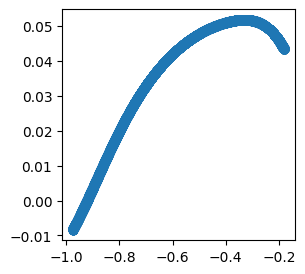

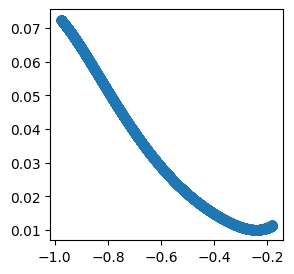

In [83]:
# Plot les fonctions de la première couche

d_in = 2
d_2 = 8
for i in range(d_in):
    for j in range(d_2):
        py_kan.get_fun(1,i,j)